# Objectives

- Generate scatter plots and regression curves for total suspended sediment and suspended sand concentration. 
- Convert concentrations to loads and repeat regression analysis.

1.) Select site and check that ten years of data is available

USGS Site Identifier: 7381495 
Location: Atchafalaya River at Melville, LA

First I looked at the comments (turning off for saving this notebook):

In [15]:
#!head -n 53 discrete_data.csv

The column headers start at line 52, so I'll read in the data frame from there:

cek: we could do this so we get directly from the web

In [16]:
import pandas
f = pandas.read_csv("discrete_data.csv",header=52)

The time period covered is about 40 years:

In [17]:
(f.DATETIME[0],f.DATETIME[410])

('1979-11-09 13:00:00', '2019-06-20 11:00:00')

In [18]:
f.head()

,SITE_NO,STATION_NM,DATETIME,DCOMMENT,ICOMMENT,SSC,DAILYFLOW,INSTFLOW,GH,P2,...,TURB63680,TEMPC,TEMPAIRC,SC,SCLAB,DSS,PH,PHLAB,END_DATE,END_TIME
0,7381495,"(COE) Atchafalaya River at Melville, LA",1979-11-09 13:00:00,S,S,200,114000.0,NaN,NaN,NaN,...,NaN,16.0,NaN,470.0,NaN,NaN,7.2,NaN,NaN,NaN
1,7381495,"(COE) Atchafalaya River at Melville, LA",1979-12-14 15:00:00,S,S,224,281000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,298.0,NaN,NaN,7.0,NaN,NaN,NaN
2,7381495,"(COE) Atchafalaya River at Melville, LA",1980-01-25 09:30:00,S,S,264,225000.0,NaN,NaN,NaN,...,NaN,9.5,NaN,281.0,NaN,NaN,6.4,NaN,NaN,NaN
3,7381495,"(COE) Atchafalaya River at Melville, LA",1980-02-07 09:30:00,S,S,235,191000.0,NaN,NaN,NaN,...,NaN,5.5,NaN,276.0,NaN,NaN,7.3,NaN,NaN,NaN
4,7381495,"(COE) Atchafalaya River at Melville, LA",1980-03-12 13:00:00,S,S,166,151000.0,NaN,NaN,NaN,...,NaN,10.5,NaN,408.0,NaN,NaN,7.7,NaN,NaN,NaN


First compare instantenous and daily flow record.

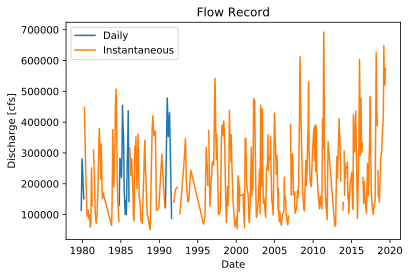

In [19]:
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
f.DATETIME = pandas.to_datetime(f.DATETIME)
plt.figure()
plt.plot(f.DATETIME,f.DAILYFLOW,f.DATETIME,f.INSTFLOW)
plt.xlabel('Date')
plt.ylabel('Discharge [cfs]')
plt.title('Flow Record')
plt.legend(['Daily','Instantaneous']);

The daily and instantaneous flow values don't overlap, so I'll just combine them.

Also, there is missing data included as NaN's, so I'll filter those out and go ahead and calculate fines as
`ssc*p63/100` and sand as `ssc*(1-p63/100)` while I'm at it:

In [20]:
import numpy as np
flow=[]
ssc=[]
flowfine=[]
fine=[]
sand=[]
for i, (daily, inst, p63) in enumerate(zip(f.DAILYFLOW,f.INSTFLOW, f.P63)):
    hasData=True
    if np.isnan(daily):
        if not np.isnan(inst):
            flow.append(inst)
            ssc.append(f.SSC[i])
        else:
            hasData=False
    else:
        flow.append(daily)
        ssc.append(f.SSC[i])
    if hasData and not np.isnan(p63):
        flowfine.append(flow[-1])
        fine.append(ssc[-1]*p63/100.0)
        sand.append(ssc[-1]*(1.-p63/100.0))
flow = np.array(flow)
ssc = np.array(ssc)
flowfine=np.array(flowfine)
fine=np.array(fine)
sand=np.array(sand)

Now plot and do linear and power regression on the total, fine, and sand concentrations 

## Linear Regression

In [21]:
from scipy import stats
ssc_lin = stats.linregress(x=flow,y=ssc)
fine_lin = stats.linregress(x=flowfine,y=fine)
sand_lin = stats.linregress(x=flowfine,y=sand)
lin = pandas.DataFrame([ssc_lin,fine_lin,sand_lin], 
                       columns=["slopes", 
                          "intercepts", 
                          "r_value", 
                          "p_value", 
                          "std err"],
                       index=['SSC','Fines','Sand'])
lin

,slopes,intercepts,r_value,p_value,std err
SSC,0.000356,103.633200,0.321079,4.819010e-11,0.000053
Fines,0.000106,127.913052,0.113719,2.344843e-02,0.000047
Sand,0.000264,-27.614932,0.721982,3.663475e-65,0.000013


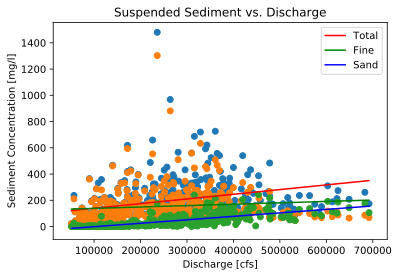

In [22]:
import math
plt.scatter(flow,ssc)
plt.scatter(flowfine,fine)
plt.scatter(flowfine,sand)
plt.plot(flow,ssc_lin[1]+ssc_lin[0]*flow,'r')
plt.plot(flowfine,fine_lin[1]+fine_lin[0]*flowfine,'g')
plt.plot(flowfine,sand_lin[1]+sand_lin[0]*flowfine,'b')
plt.legend(['Total','Fine','Sand'])
plt.xlabel('Discharge [cfs]')
plt.title('Suspended Sediment vs. Discharge')
plt.ylabel('Sediment Concentration [mg/l]');

## Power Law Regression

In [23]:
from scipy import stats
log_flow = np.log(flow)
log_flowfine = np.log(flowfine)
log_ssc = np.log(ssc)
log_fine = np.log(fine)
sand_indeces = np.where(sand > 0.0)
log_flowfine_sand = np.log(flowfine[sand_indeces])
log_sand = np.log(sand[sand_indeces])
ssc_pow = stats.linregress(x=log_flow,y=log_ssc)
fine_pow = stats.linregress(x=log_flowfine,y=log_fine)
sand_pow = stats.linregress(x=log_flowfine_sand,y=log_sand)
pow = pandas.DataFrame([ssc_pow,fine_pow,sand_pow], 
                       columns=["slopes", 
                          "intercepts", 
                          "r_value", 
                          "p_value", 
                          "std err"],
                       index=['SSC','Fines','Sand'])
pow

,slopes,intercepts,r_value,p_value,std err
SSC,0.734762,-4.001486,0.586917,2.152241e-38,0.050807
Fines,0.435611,-0.539711,0.365857,5.102157e-14,0.055755
Sand,2.505807,-28.139084,0.834290,2.446685e-101,0.084503


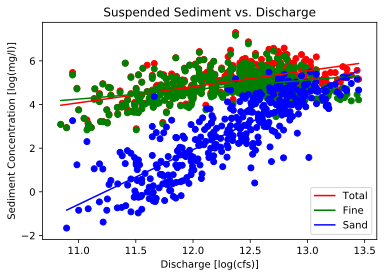

In [24]:
import math
plt.scatter(log_flow,log_ssc,c='r')
plt.scatter(log_flowfine,log_fine,c='g')
plt.scatter(log_flowfine_sand,log_sand,c='b')
plt.plot(log_flow,ssc_pow[1]+ssc_pow[0]*log_flow,'r')
plt.plot(log_flowfine,fine_pow[1]+fine_pow[0]*log_flowfine,'g')
plt.plot(log_flowfine_sand,sand_pow[1]+sand_pow[0]*log_flowfine_sand,'b')
plt.legend(['Total','Fine','Sand'])
plt.title('Suspended Sediment vs. Discharge')
plt.xlabel('Discharge [log(cfs)]')
plt.ylabel('Sediment Concentration [log(mg/l)]');

# Sediment Load

Sediment load is the sediment discharge (product of water discharge and concentration.

## Linear Regression

In [25]:
K=.0027 #conversion factor to get Q_s from discharge and concentration in mg/l
q_total = flow*ssc*K
q_fine = flowfine*fine*K
q_sand = flowfine*sand*K
q_total_lin = stats.linregress(x=flow,y=q_total)
q_fine_lin = stats.linregress(x=flowfine,y=q_fine)
q_sand_lin = stats.linregress(x=flowfine,y=q_sand)
q_lin = pandas.DataFrame([q_total_lin,q_fine_lin,q_sand_lin], 
                       columns=["slopes", 
                          "intercepts", 
                          "r_value", 
                          "p_value", 
                          "std err"],
                       index=['SSC Load','Fines Load','Sand Load'])
q_lin

,slopes,intercepts,r_value,p_value,std err
SSC Load,0.712903,-31173.342117,0.673341,3.718344e-54,0.039237
Fines Load,0.372013,16377.957448,0.485260,7.646737e-25,0.033727
Sand Load,0.352196,-49950.466045,0.791032,2.558973e-86,0.013705


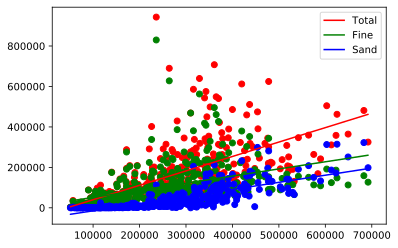

In [26]:
plt.scatter(flow,q_total,c='r')
plt.scatter(flowfine,q_fine,c='g')
plt.scatter(flowfine,q_sand,c='b')
plt.plot(flow,q_total_lin[1]+q_total_lin[0]*flow,'r')
plt.plot(flowfine,q_fine_lin[1]+q_sand_lin[0]*flowfine,'g')
plt.plot(flowfine,q_sand_lin[1]+q_sand_lin[0]*flowfine,'b')
plt.legend(['Total','Fine','Sand']);

## Power Regression

In [27]:
from scipy import stats
log_flow = np.log(flow)
log_flowfine = np.log(flowfine)
log_q_total = np.log(q_total)
log_q_fine = np.log(q_fine)
q_sand_indeces = np.where(q_sand > 0.0)
log_flowfine_q_sand = np.log(flowfine[q_sand_indeces])
log_q_sand = np.log(sand[q_sand_indeces])
q_total_pow = stats.linregress(x=log_flow,y=log_q_total)
q_fine_pow = stats.linregress(x=log_flowfine,y=log_q_fine)
q_sand_pow = stats.linregress(x=log_flowfine_sand,y=log_q_sand)
pow = pandas.DataFrame([q_total_pow,q_fine_pow,q_sand_pow], 
                       columns=["slopes", 
                          "intercepts", 
                          "r_value", 
                          "p_value", 
                          "std err"],
                       index=['Total Load','Fines Load','Sand Load'])
pow

,slopes,intercepts,r_value,p_value,std err
Total Load,1.734762,-9.915989,0.863420,2.505447e-120,0.050807
Fines Load,1.435611,-6.454214,0.791611,1.575747e-86,0.055755
Sand Load,2.505807,-28.139084,0.834290,2.446685e-101,0.084503


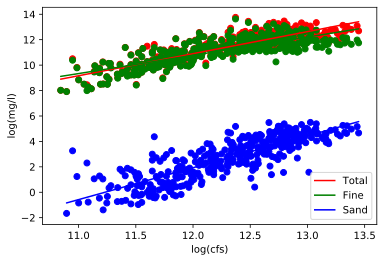

In [28]:
plt.scatter(log_flow,log_q_total,c='r')
plt.scatter(log_flowfine,log_q_fine,c='g')
plt.scatter(log_flowfine_sand,log_q_sand,c='b')
plt.plot(log_flow,q_total_pow[1]+q_total_pow[0]*log_flow,'r')
plt.plot(log_flowfine,q_fine_pow[1]+q_fine_pow[0]*log_flowfine,'g')
plt.plot(log_flowfine_sand,q_sand_pow[1]+q_sand_pow[0]*log_flowfine_sand,'b')
plt.legend(['Total','Fine','Sand'])
plt.xlabel('log(cfs)')
plt.ylabel('log(mg/l)');